In [313]:
# from pymasker import LandsatMasker
# from pymasker import LandsatConfidence

# # load the QA band directly
# #
# # The "collection" parameter is required for landsat to specify the collection
# # number. Acceptable number: 0 (pre-collection), 1 (collection-1)
# #
# masker = LandsatMasker(r'..\Data\raw sat images-2014-2019\LC08_L1TP_036025_20170403_20170414_01_T1\LC08_L1TP_036025_20170403_20170414_01_T1_BQA.TIF', collection=1)

# # algorithm has high confidence that this condition exists
# # (67-100 percent confidence)
# conf = LandsatConfidence.low

# # Get mask indicating cloud pixels with high confidence
# mask = masker.get_snow_mask(conf)

# # save the result
# masker.save_tif(mask, 'result10.tif')

In [314]:
## change kernel (environment) to Acolite_env to run this cell
#!python ..\Input_models\acolite\launch_acolite.py --cli --settings=acolite_settings.txt --image=..\Data\Satellite\raw-L8-2014-2019\ImagesList_L8.txt

In [315]:
# Run this code in conda environment "MDN" to make MDN part working correctly.

In [623]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr

In [733]:
pd.set_option('display.max_rows' ,500)

In [625]:
pd.set_option('display.max_columns' ,500)

#  field chla data preparation

In [626]:
field_data = pd.read_csv('../Data/BP_data.csv', skiprows=[1], parse_dates=['Date'], index_col= 'SampleID')
field_data

,Dataset,Date,Time,SiteNumber,latitude,Longitude,BottomDepth,sampledepth,SecchiDiskDepth,SamplingInScum,Lab_Chla,TSS,PARExtinction,TurbidityLab,TurbShallowField,DOC,Bat,WindDir,WindSp,AirTemp,RelativeHum,BarometricPress,DailyRain,PARAirFlags,PARW1,PARW2,CO2Shallow,CO2Deep,TempShallow,SpCondShallow,pHShallow,pHmVShallow,ChlRFUShallow,ChlorophyllShallow,BGAPCShallowRFU,BGAPCShallow,ODOSatShallow,ODOShallow,TempDeep,SpCondDeep,pHDeep,pHmVDeep,BGAPCDeep,BGAPCDeepRFU,ODOSatDeep,ODODeep,CDOM,CDOMmV,Temp00,Temp01,Temp02,Temp03,Temp04,shallow_sonde_biofouling_outlier,Lab_chlaOutlier,biomassCyanobacteria,biomassChlorophyte,biomassEuglenophyte,biomassChrysophyte,biomassDiatom,biomassCryptophyte,biomassDinoflagellate,biomassTotal,Cyanobacteria,Chlorophyte,Euglenophyte,Chrysophyte,Diatom,Cryptophyte,Dinoflagellate,cellcountTotal,Bluegreen_Anabaena,Bluegreen_AgmenellumMerismopedia,Bluegreen_Anacystis,Bluegreen_Gomphosphaeria,Bluegreen_Oscillatoria,Bluegreen_Aphanizomenon,Green_Chlorella,Green_Clostrium,Green_Scenedesmus,Green_Ankistrodesmus,Green_Oocystis,Green_Chodetella,Green_Botryococcus,Green_Mougeotia,Green_Phytoconis,Green_Sphaerocystis,Green_Spirogyra,Green_Tetraedron,Green_Polyedriopsis,Green_Ulothrix,Green_Pediastrum,Green_Schroderia,Diatom_Cyclotella,Diatom_Synedra,Diatom_Cocconeis,Diatom_Nitzchia,Diatom_Navicula,Diatom_Fragillaria,Diatom_Tabellaria,Diatom_Gomphenema,Diatom_Astrionella,Flagellates,Other
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Buoy,2014-06-11,6:15:00 PM,1,50.586139,-105.384833,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,NaN,12.5,269.0,3.4,17.50,31.0,957.0,0.0,405.0,NaN,NaN,342.7,318.3,17.28,480.0,8.53,-116.3,2.8,11.1,3.6,11770.0,NaN,8.77,17.22,472.0,8.63,-113.9,14634.0,4.0,98.3,9.45,36.4,90.70,NaN,17.26,17.25,17.28,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Buoy,2014-06-11,6:30:00 PM,1,50.586139,-105.384833,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,NaN,12.6,198.0,4.5,17.56,38.0,957.0,0.0,410.0,NaN,NaN,336.8,329.4,17.30,481.0,8.51,-115.1,2.6,10.7,3.4,11127.0,NaN,8.80,17.23,472.0,8.67,-116.3,14856.0,4.1,98.4,9.45,36.5,90.91,NaN,17.27,17.24,17.27,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,Calibration,2019-09-03,12:05:00 PM,1,50.586139,-105.384833,4.3,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,Calibration,2019-09-03,12:05:00 PM,1,50.586139,-105.384833,4.3,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [627]:
#buoy calibration
filt_dataset = field_data['Dataset'] == 'Buoy'
#field_data.loc[filt_dataset, 'Lab_Chla'] = ((100/105) * field_data[filt_dataset]['ChlRFUShallow']) ** (100/29)
field_data.loc[filt_dataset, 'Lab_Chla'] = (5 * field_data[filt_dataset]['BGAPCShallowRFU']) ** (100/99)
field_data['Lab_Chla'].head()

SampleID
1    18.533269
2    17.493540
3    16.454429
4    19.053354
5    16.454429
Name: Lab_Chla, dtype: float64

In [628]:
# drop the buoy observations associated with biofouling error
field_data = field_data[field_data['shallow_sonde_biofouling_outlier'] != 1].copy()
# drop the associated column 
field_data.drop('shallow_sonde_biofouling_outlier', axis=1, inplace=True)

In [629]:
# drop the lab observations labeld as error
field_data = field_data[field_data.Lab_chlaOutlier != 1].copy()
# drop the associated column 
field_data.drop('Lab_chlaOutlier', axis=1, inplace=True)
field_data.shape

(108778, 102)

In [630]:
# drop the observations containing bottom signal
field_data = field_data[~(field_data.SecchiDiskDepth >= field_data.BottomDepth)].copy()
field_data.shape

(108754, 102)

In [631]:
# filt_station = field_data['SiteNumber'] <5
# field_data = field_data[filt_station]

In [700]:
filt_station = field_data['SiteNumber'] > 3
corr_data = field_data[filt_station]

In [701]:
corr_data.SiteNumber.where(corr_data.SiteNumber!=10, other = 9, inplace=True)
corr_data.SiteNumber.where(corr_data.SiteNumber!=11, other = 12, inplace=True)
corr_data.SiteNumber.where(corr_data.SiteNumber!=13, other = 12, inplace=True)
corr_data.SiteNumber.where(corr_data.SiteNumber!=14, other = 15, inplace=True)
corr_data.SiteNumber.where(corr_data.SiteNumber!=16, other = 15, inplace=True)

C:\Users\amchegoo\Anaconda3\envs\p2_env\lib\site-packages\pandas\core\generic.py:9004: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
C:\Users\amchegoo\Anaconda3\envs\p2_env\lib\site-packages\pandas\core\generic.py:9004: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
C:\Users\amchegoo\Anaconda3\envs\p2_env\lib\site-packages\pandas\core\generic.py:9004: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [702]:
corr_data.head()

,Dataset,Date,Time,SiteNumber,latitude,Longitude,BottomDepth,sampledepth,SecchiDiskDepth,SamplingInScum,Lab_Chla,TSS,PARExtinction,TurbidityLab,TurbShallowField,DOC,Bat,WindDir,WindSp,AirTemp,RelativeHum,BarometricPress,DailyRain,PARAirFlags,PARW1,PARW2,CO2Shallow,CO2Deep,TempShallow,SpCondShallow,pHShallow,pHmVShallow,ChlRFUShallow,ChlorophyllShallow,BGAPCShallowRFU,BGAPCShallow,ODOSatShallow,ODOShallow,TempDeep,SpCondDeep,pHDeep,pHmVDeep,BGAPCDeep,BGAPCDeepRFU,ODOSatDeep,ODODeep,CDOM,CDOMmV,Temp00,Temp01,Temp02,Temp03,Temp04,biomassCyanobacteria,biomassChlorophyte,biomassEuglenophyte,biomassChrysophyte,biomassDiatom,biomassCryptophyte,biomassDinoflagellate,biomassTotal,Cyanobacteria,Chlorophyte,Euglenophyte,Chrysophyte,Diatom,Cryptophyte,Dinoflagellate,cellcountTotal,Bluegreen_Anabaena,Bluegreen_AgmenellumMerismopedia,Bluegreen_Anacystis,Bluegreen_Gomphosphaeria,Bluegreen_Oscillatoria,Bluegreen_Aphanizomenon,Green_Chlorella,Green_Clostrium,Green_Scenedesmus,Green_Ankistrodesmus,Green_Oocystis,Green_Chodetella,Green_Botryococcus,Green_Mougeotia,Green_Phytoconis,Green_Sphaerocystis,Green_Spirogyra,Green_Tetraedron,Green_Polyedriopsis,Green_Ulothrix,Green_Pediastrum,Green_Schroderia,Diatom_Cyclotella,Diatom_Synedra,Diatom_Cocconeis,Diatom_Nitzchia,Diatom_Navicula,Diatom_Fragillaria,Diatom_Tabellaria,Diatom_Gomphenema,Diatom_Astrionella,Flagellates,Other
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109169,Survey,2015-06-01,3:10:00 PM,5,50.57318,-105.34174,2.4,1.0,1.3,NaN,13.73,5.0,1.282,10.0,5.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109170,Survey,2015-06-10,2:20:00 PM,5,50.57318,-105.34174,2.4,1.0,0.6,NaN,45.37,15.0,1.774,24.0,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109171,Survey,2015-07-13,10:10:00 AM,5,50.57318,-105.34174,2.4,1.0,1.2,NaN,14.25,3.0,1.621,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109172,Survey,2015-08-24,2:10:00 PM,5,50.57318,-105.34174,2.5,1.0,0.4,NaN,99.77,21.0,2.459,27.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109173,Survey,2015-10-21,11:40:00 AM,5,50.57318,-105.34174,2.1,1.0,0.8,NaN,17.13,12.0,2.634,4.2,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [703]:
corr_data_grouped = corr_data.groupby(['Date','SiteNumber']).median()
corr_data_grouped.head()

latitude  Longitude  BottomDepth  sampledepth  \
Date       SiteNumber                                                  
2015-06-01 4           50.58653 -105.38421          4.0         2.00   
           5           50.57318 -105.34174          2.4         1.00   
           6           50.61780 -105.44383          4.6         1.00   
           7           50.65615 -105.52058          4.4         2.25   
           8           50.68295 -105.55910          3.9         1.00   

                       SecchiDiskDepth  SamplingInScum  Lab_Chla  TSS  \
Date       SiteNumber                                                   
2015-06-01 4                      1.35             NaN     20.47  6.5   
           5                      1.30             NaN     13.73  5.0   
           6                      1.10             NaN     33.08  6.0   
           7                      1.30             NaN     18.50  5.0   
           8                      1.80             NaN      9.84  4.0   

                       PARExtinction  TurbidityLab  TurbShallowField  DOC  \
Date       SiteNumber                                                       
2015-06-01 4                   1.145          8.45               3.4  NaN   
           5                   1.282         10.00               5.3  NaN   
           6                   1.092         22.00               4.4  NaN   
           7                   0.987          8.65               4.1  NaN   
           8                   0.879          3.70               3.9  NaN   

                       Bat  WindDir  WindSp  AirTemp  RelativeHum  \
Date       SiteNumber                                               
2015-06-01 4           NaN      NaN     NaN      NaN          NaN   
           5           NaN      NaN     NaN      NaN          NaN   
           6           NaN      NaN     NaN      NaN          NaN   
           7           NaN      NaN     NaN      NaN          NaN   
           8           NaN      NaN     NaN      NaN          NaN   

                       BarometricPress  DailyRain  PARAirFlags  PARW1  PARW2  \
Date       SiteNumber                                                          
2015-06-01 4                       NaN        NaN          NaN    NaN    NaN   
           5                       NaN        NaN          NaN    NaN    NaN   
           6                       NaN        NaN          NaN    NaN    NaN   
           7                       NaN        NaN          NaN    NaN    NaN   
           8                       NaN        NaN          NaN    NaN    NaN   

                       CO2Shallow  CO2Deep  TempShallow  SpCondShallow  \
Date       SiteNumber                                                    
2015-06-01 4                  NaN      NaN          NaN            NaN   
           5                  NaN      NaN          NaN            NaN   
           6                  NaN      NaN          NaN            NaN   
           7                  NaN      NaN          NaN            NaN   
           8                  NaN      NaN          NaN            NaN   

                       pHShallow  pHmVShallow  ChlRFUShallow  \
Date       SiteNumber                                          
2015-06-01 4                 NaN          NaN            NaN   
           5                 NaN          NaN            NaN   
           6                 NaN          NaN            NaN   
           7                 NaN          NaN            NaN   
           8                 NaN          NaN            NaN   

                       ChlorophyllShallow  BGAPCShallowRFU  BGAPCShallow  \
Date       SiteNumber                                                      
2015-06-01 4                          NaN              NaN           NaN   
           5                          NaN              NaN           NaN   
           6                          NaN              NaN           NaN   
           7                          NaN              NaN           NaN 

In [704]:
corr_data_grouped = corr_data_grouped[['Lab_Chla' ,'TSS' ,'TurbShallowField','SecchiDiskDepth']].copy()

In [705]:
corr_data_grouped['Lab_Chla'] = np.log10(corr_data_grouped['Lab_Chla']).copy()
corr_data_grouped['TSS'] = np.log10(corr_data_grouped['TSS']).copy()
corr_data_grouped['TurbShallowField'] = np.log10(corr_data_grouped['TurbShallowField']).copy()

C:\Users\amchegoo\Anaconda3\envs\p2_env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [706]:
corr_data_grouped.rename(columns={'Lab_Chla': 'log Chla', 'TSS': 'log TSS','TurbShallowField': 'log Turbidity','SecchiDiskDepth': 'SDD'}, inplace=True)

In [707]:
corr_data_grouped_final = corr_data_grouped.dropna(how='any',axis=0)
corr_data_grouped_final.head()

log Chla   log TSS  log Turbidity   SDD
Date       SiteNumber                                         
2015-06-01 4           1.311118  0.812913       0.531479  1.35
           5           1.137671  0.698970       0.724276  1.30
           6           1.519566  0.778151       0.643453  1.10
           7           1.267172  0.698970       0.612784  1.30
           8           0.992995  0.602060       0.591065  1.80

In [708]:
corr_data_grouped_final.reset_index(inplace=True)
corr_data_grouped_final.head()

,Date,SiteNumber,log Chla,log TSS,log Turbidity,SDD
0,2015-06-01,4,1.311118,0.812913,0.531479,1.35
1,2015-06-01,5,1.137671,0.698970,0.724276,1.30
2,2015-06-01,6,1.519566,0.778151,0.643453,1.10
3,2015-06-01,7,1.267172,0.698970,0.612784,1.30
4,2015-06-01,8,0.992995,0.602060,0.591065,1.80


In [709]:
import seaborn as sns

In [710]:
corr_data_grouped_final['SiteNumber'] = corr_data_grouped_final['SiteNumber'].astype(str).copy()

<ipython-input-710-92135fe5815c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data_grouped_final['SiteNumber'] = corr_data_grouped_final['SiteNumber'].astype(str).copy()


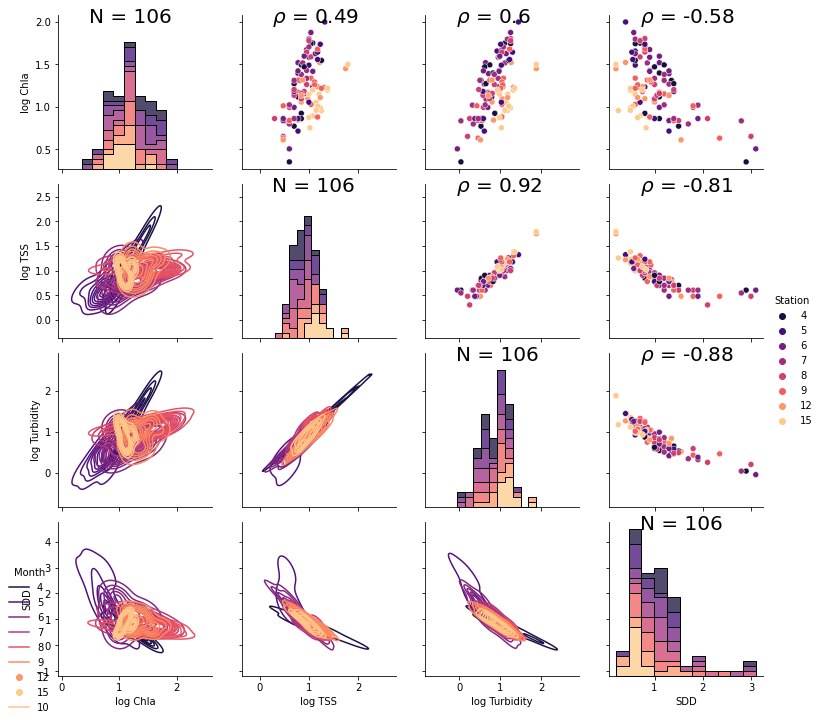

In [732]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    
# Function to calculate Number of observation to plot on histograms
def num_obs(x, **kwargs):
    
    # Calculate the value
    num_obs = np.count_nonzero(~np.isnan(x))
    # Make the label
    label = 'N = ' + str(num_obs)
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    
grid = sns.PairGrid(data= corr_data_grouped_final, vars = ['log Chla','log TSS', 'log Turbidity', 'SDD'])
# Map the plots to the locations

grid = grid.map_upper(corr)
grid = grid.map_diag(num_obs)

# Now set parameters needed for `hue`
hue_vals = corr_data_grouped_final["SiteNumber"]
hue_vals2 = corr_data_grouped_final.Date.dt.month

grid.hue_names = corr_data_grouped_final["SiteNumber"].unique()
palette_value = sns.color_palette("magma", len(grid.hue_names))

grid.hue_names = corr_data_grouped_final.Date.dt.month.unique()
palette_value2 = sns.color_palette("magma", len(grid.hue_names))

grid = grid.map_upper(sns.scatterplot, hue = hue_vals, palette = palette_value)
grid = grid.add_legend(title = 'Station')
grid = grid.map_lower(sns.kdeplot, hue = hue_vals2, palette = palette_value2)
grid = grid.add_legend(title = 'Month',loc=3)
grid = grid.map_diag(sns.histplot, hue = hue_vals, palette = palette_value,multiple="stack", element="step");
#grid = grid.add_legend(title = 'Station')
                    
 # vars = ['Lab_Chla','TSS', 'TurbShallowField', 'SecchiDiskDepth'], hue="SiteNumber",hue_order=['4','5','6','7','8','9','12','15'],palette='magma')

In [644]:
# grid.savefig('corrplot.png',dpi=500, format='png')

In [645]:
# averaging field chla data over date and station
chl_data = field_data.groupby(['Date', 'SiteNumber', 'latitude', 'Longitude']).agg({'Lab_Chla' :'median'})
chl_data

,,,,Lab_Chla
Date,SiteNumber,latitude,Longitude,
2014-01-06,2,50.585203,-105.385823,NaN
2014-01-13,2,50.585203,-105.385823,6.000000
...,...,...,...,...
2019-10-02,1,50.586139,-105.384833,39.946201
2019-10-03,1,50.586139,-105.384833,41.518573


In [646]:
# drop (dates,stations) with no chla measured
chl_data.dropna(axis=0, inplace=True)
chl_data.head()

,,,,Lab_Chla
Date,SiteNumber,latitude,Longitude,
2014-01-13,2,50.585203,-105.385823,6.0
2014-01-27,2,50.585203,-105.385823,7.0
2014-02-10,2,50.585203,-105.385823,19.0
2014-02-24,2,50.585203,-105.385823,14.0
2014-03-10,2,50.585203,-105.385823,8.0


In [647]:
chl_data.reset_index(level=['Date', 'SiteNumber', 'latitude', 'Longitude'], inplace=True)
chl_data.index
chl_data.dtypes

Date          datetime64[ns]
SiteNumber             int64
latitude             float64
Longitude            float64
Lab_Chla             float64
dtype: object

# Extract satelite data

In [648]:
# create a dataframe for images in the directory
import os, fnmatch

listOfFiles = os.listdir('../Data/Satellite/Processed_sat-2014-2019')
pattern = "S2*_L2W.nc"
img_list = []
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            img_list.append(entry)

if fnmatch.fnmatch(pattern, 'S2*'):
    img_dates = [i[8:18] for i in img_list] #for S2
elif fnmatch.fnmatch(pattern, 'L8*'):
    img_dates = [i[7:17] for i in img_list] #for L8
    
number_of_images = len(img_list)
sat_dates = pd.DataFrame(data = img_dates, columns = ['Date'], index = range(0, number_of_images))
sat_dates['#img'] = range(0, number_of_images)
sat_dates.head()
sat_dates

,Date,#img
0,2017_04_08,0
1,2017_04_15,1
...,...,...
70,2019_10_20,70
71,2019_10_30,71


In [649]:
sat_dates.sort_values('Date',inplace = True)
sat_dates.head()

,Date,#img
0,2017_04_08,0
1,2017_04_15,1
2,2017_04_28,2
3,2017_05_05,3
4,2017_05_18,4


In [650]:
sat_dates['Date'] = pd.to_datetime(sat_dates['Date'], format='%Y_%m_%d')

In [651]:
# create a dataframe from merging chla data and the closest image within specified time lag
merged_data = pd.merge_asof(chl_data.rename(columns={'Date':'Date_insitu'}), sat_dates.rename(columns={'Date':'Date_sat'}), left_on='Date_insitu', right_on='Date_sat',direction='nearest',tolerance=pd.Timedelta('3d'))
merged_data

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img
0,2014-01-13,2,50.585203,-105.385823,6.000000,NaT,NaN
1,2014-01-27,2,50.585203,-105.385823,7.000000,NaT,NaN
...,...,...,...,...,...,...,...
1206,2019-10-02,1,50.586139,-105.384833,39.946201,2019-10-05,41.0
1207,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41.0


In [652]:
# drop samples for which there is no image whithin specifies time lag
merged_data.dropna(axis=0, subset = ['#img'], inplace=True)
merged_data

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img
583,2017-04-10,2,50.585203,-105.385823,20.000000,2017-04-08,0.0
584,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3.0
...,...,...,...,...,...,...,...
1206,2019-10-02,1,50.586139,-105.384833,39.946201,2019-10-05,41.0
1207,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41.0


In [734]:
# compute date diff parameters
merged_data['date_diff'] = abs(merged_data['Date_sat'] - merged_data['Date_insitu'])
merged_data

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff
583,2017-04-10,2,50.585203,-105.385823,20.000000,2017-04-08,0.0,2 days
584,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3.0,3 days
592,2017-05-15,1,50.586139,-105.384833,4.568889,2017-05-18,4.0,3 days
593,2017-05-15,4,50.586530,-105.384210,5.910000,2017-05-18,4.0,3 days
594,2017-05-15,5,50.573180,-105.341740,5.170000,2017-05-18,4.0,3 days
595,2017-05-15,6,50.617800,-105.443830,6.870000,2017-05-18,4.0,3 days
596,2017-05-15,7,50.656150,-105.520580,6.270000,2017-05-18,4.0,3 days
597,2017-05-15,8,50.682950,-105.559100,6.870000,2017-05-18,4.0,3 days
598,2017-05-15,10,50.711590,-105.587770,6.870000,2017-05-18,4.0,3 days
599,2017-05-15,11,50.720740,-105.606940,12.900000,2017-05-18,4.0,3 days


In [654]:
# To include just the closest sample when more than one sample in the same station colected in +-3 days and fall into a same image
merged_data_3daylag = merged_data.sort_values(by=['Date_sat', 'SiteNumber', 'date_diff']).drop_duplicates(subset=['#img', 'SiteNumber'], keep='first', inplace=False)
merged_data_3daylag

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff
583,2017-04-10,2,50.585203,-105.385823,20.000000,2017-04-08,0.0,2 days
584,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3.0,3 days
...,...,...,...,...,...,...,...,...
1199,2019-09-25,1,50.586139,-105.384833,37.850673,2019-09-25,40.0,0 days
1207,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41.0,2 days


In [655]:
merged_data_3daylag.reset_index(inplace= True)
merged_data_3daylag.drop('index', axis=1, inplace=True)

In [656]:
merged_data_3daylag['#img'] = merged_data_3daylag['#img'].astype('int32', copy = True)
merged_data_3daylag

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff
0,2017-04-10,2,50.585203,-105.385823,20.000000,2017-04-08,0,2 days
1,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3,3 days
...,...,...,...,...,...,...,...,...
185,2019-09-25,1,50.586139,-105.384833,37.850673,2019-09-25,40,0 days
186,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41,2 days


In [657]:
# # still not working for S2 images because of different bands in S2A and S2B. I think the best practice for S2 images is to read A and B in different datasets and then change the keys in the second one to be consistent with the first one and then merge them in one dataset.
path_img = '../Data/Satellite/Processed_sat-2014-2019/'

# for index in range(len(img_list)):
#     if index == 0:
#         imgs = xr.open_dataset(path_img + img_list[index], decode_times=False)
#         imgs.coords['Date'] = sat_dates['Date'][index]
#     else:
#         ds = xr.open_dataset(path_img + img_list[index], decode_times=False)
#         ds.coords['Date'] = sat_dates['Date'][index]
#         imgs = xr.concat([imgs,ds],'Date').copy()

In [658]:
# # I couldnt use this method becasue of inconsistencies in netcdf files
# imgs = xr.open_mfdataset([os.path.join(path, name) for name in img_list], combine = 'nested', compat='override',decode_times=False)

In [659]:
# extracting reflectance values of correspond pixels to in-situ data
Ref = [[]*0]*0
pixel = [[]*0]*0
for index, row in merged_data_3daylag.iterrows():
    #print(index)
    ds = nc.Dataset('../Data/Satellite/Processed_sat-2014-2019/' + img_list[merged_data_3daylag.loc[index]['#img']])
    keys = ds.variables.keys()
    ds_1D = {}
    for key in keys:
        ds_1D[key] = ds.variables[key][:].flatten(order='C')

    dist = ((ds_1D['lon'][:] - row['Longitude']) ** 2 + (ds_1D['lat'][:] - row['latitude']) ** 2) ** (1/2) 
    idx_mins = dist.argsort()[:9]
    #print(idx_mins)
    idx_min = idx_mins[0]
    
    pix_Y = idx_min // ds.dimensions['x'].size
    pix_X = idx_min % ds.dimensions['x'].size
    pix = [pix_Y, pix_X]
    pixel.append(pix)
    
    Rrs = []
    for key in keys:
        if 'Rrs' in key:   # products: Rrs, rhot, and rhorc      
            if (ds_1D['l2_flags'][idx_min]) == 0: # I added this condition to mask rhot and rhorc products which are not filtered by default in Acolite 
    #           Rrs.append((ds_1D[key][idx_mins]).mean())
                Rrs.append((ds_1D[key][idx_min]))
            
    Ref.append(Rrs)

the result of above method to extract reflectance values was checked with PixEx method in SNAP. there is slight different in extracted pixelss. from 9 pixels extrscted 2 of them were different between two mwthods. but dont think it has much effect on results. also the above method put nan for if the window contains even one nan value. which I think makes sense to avoid adjacency effects of cloud and so on. however it can be replaced with nonmean mehthod.

In [660]:
# name of columns to add to dataframe
#added_ref = ['Rrs_443', 'Rrs_492', 'Rrs_560' , 'Rrs_665', 'Rrs_704', 'Rrs_740', 'Rrs_783', 'Rrs_833', 'Rrs_865', 'Rrs_945', 'Rrs_1373', 'Rrs_1614' , 'Rrs_2202'] # for S2-rhot
added_ref = ['Rrs_443', 'Rrs_492', 'Rrs_560' , 'Rrs_665', 'Rrs_704', 'Rrs_740', 'Rrs_783', 'Rrs_833', 'Rrs_865', 'Rrs_1614' , 'Rrs_2202'] # for S2
#added_ref = ['Rrs_443', 'Rrs_483', 'Rrs_561' , 'Rrs_655', 'Rrs_865', 'Rrs_1609', 'Rrs_2201'] # for L8

In [661]:
# crate a dataframe of ref data
sat_ref = pd.DataFrame(data = Ref, columns = added_ref)
sat_ref

,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000036,0.002302,0.008244,0.001386,0.000821,-0.000318,-0.000481,-0.000355,-0.000520,0.000018,0.0
...,...,...,...,...,...,...,...,...,...,...,...
185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,0.001056,0.003260,0.008091,0.004065,0.005244,0.003641,0.003520,0.003421,0.002957,0.000576,0.0


# attach extracted ref data to field dataframe


In [662]:
# concating chla and ref dataframes 
samples = pd.concat([merged_data_3daylag, pd.DataFrame(pixel,columns=['pix_Y','pix_X']), sat_ref], axis = 1)
print(samples.shape)
samples

(187, 21)


,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff,pix_Y,pix_X,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
0,2017-04-10,2,50.585203,-105.385823,20.000000,2017-04-08,0,2 days,344,490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3,3 days,344,490,0.000036,0.002302,0.008244,0.001386,0.000821,-0.000318,-0.000481,-0.000355,-0.000520,0.000018,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2019-09-25,1,50.586139,-105.384833,37.850673,2019-09-25,40,0 days,342,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41,2 days,342,491,0.001056,0.003260,0.008091,0.004065,0.005244,0.003641,0.003520,0.003421,0.002957,0.000576,0.0


# bad pixel handeling

 I decided to use only acolite to remove bad pixels (it includes removing cloud, some shadows and negative refs) and then use a outlier detection to remove bad refs. I thnik it is enough based on no significant difference with method below which was based on manuall detection.

In [663]:
#drop missing values in ref 
samples = samples.dropna(axis=0, how='any').copy()
sat_ref = sat_ref.dropna(axis=0, how='any').copy()
samples.shape
print(sat_ref.shape)

(139, 11)


In [664]:
# samples.to_csv('vis_forbadpixeldetermination.csv')
# bad_pixels = np.genfromtxt('badpixels_L8_samedaySamples.csv', delimiter=',')
# filt_bad_pixels = bad_pixels < 1
# samples_filtered = samples[filt_bad_pixels].copy()
# samples_filtered

In [665]:
#samples.filter(like='Rrs_').transpose().plot()

In [666]:
filt_outliers = samples['Rrs_443'].between(samples['Rrs_443'].quantile(.05), samples['Rrs_443'].quantile(.95))
samples = samples[filt_outliers]
sat_ref = sat_ref[filt_outliers][:]
#samples.filter(like='Rrs_').transpose().plot()
print(samples.shape)
print(sat_ref.shape)

(125, 21)
(125, 11)


In [667]:
samples

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff,pix_Y,pix_X,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
1,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3,3 days,344,490,0.000036,0.002302,0.008244,0.001386,0.000821,-0.000318,-0.000481,-0.000355,-0.000520,0.000018,0.0
2,2017-05-18,1,50.586139,-105.384833,3.033477,2017-05-18,4,0 days,342,491,0.000350,0.002114,0.007294,0.001184,0.001301,0.000634,0.001047,0.000987,0.000804,0.000217,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2019-09-23,15,50.735690,-105.626390,11.320000,2019-09-22,39,1 days,64,208,0.003406,0.004933,0.011380,0.006363,0.005909,0.003568,0.003143,0.002944,0.002859,0.000738,0.0
186,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41,2 days,342,491,0.001056,0.003260,0.008091,0.004065,0.005244,0.003641,0.003520,0.003421,0.002957,0.000576,0.0


# feature engineering


In [1486]:
y = samples.Lab_Chla
X = samples.drop('Lab_Chla', axis = 1)
X.head()

,Date_insitu,SiteNumber,latitude,Longitude,Date_sat,#img,date_diff,pix_Y,pix_X,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
1,2017-05-08,2,50.585203,-105.385823,2017-05-05,3,3 days,344,490,0.000036,0.002302,0.008244,0.001386,0.000821,-0.000318,-0.000481,-0.000355,-0.000520,0.000018,0.000000
2,2017-05-18,1,50.586139,-105.384833,2017-05-18,4,0 days,342,491,0.000350,0.002114,0.007294,0.001184,0.001301,0.000634,0.001047,0.000987,0.000804,0.000217,0.000000
3,2017-05-15,4,50.586530,-105.384210,2017-05-18,4,3 days,341,492,0.000301,0.002465,0.007444,0.001020,0.000942,0.000828,0.000831,0.000838,0.000544,0.000000,0.000074
4,2017-05-15,5,50.573180,-105.341740,2017-05-18,4,3 days,366,542,0.001168,0.003946,0.010223,0.002869,0.002622,0.001241,0.001239,0.001751,0.000860,0.000320,0.000000
5,2017-05-15,6,50.617800,-105.443830,2017-05-18,4,3 days,283,422,0.000228,0.002092,0.005384,0.000941,0.001093,0.001267,0.001492,0.001270,0.001402,0.000183,0.000000


In [1487]:
y_trans_log10 = np.log10(y)
len(y_trans_log10)

125

In [1488]:
X['Month'] = X['Date_sat'].dt.month

In [1527]:
# computing traditional models
X['NDCI'] = np.log1p((X['Rrs_704']- X['Rrs_665']) / (X['Rrs_704']+  X['Rrs_665']))
X['M09'] = np.log10(X['Rrs_704'] / X['Rrs_665'])
#X['T07'] = X['Rrs_665'] / X['Rrs_560']
X['D05'] = np.log1p((X['Rrs_665']**(-1) - X['Rrs_704']**(-1)) * X['Rrs_740'])
X['OC2'] = X['Rrs_492'] / X['Rrs_560']
X['OC3'] = np.log10(pd.concat([X['Rrs_492'],X['Rrs_443']], axis=1).max(axis=1) / X['Rrs_560'])

In [1537]:
selected_features = []
selected_features = added_ref[:7]
# selected_features.append('SiteNumber')
# selected_features.append('Month')
#selected_features.append('NDCI')
#selected_features.append('M09')
#selected_features.append('D05')
#selected_features.append('OC3')
X_sel = pd.DataFrame(X[selected_features])
X_sel

,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783
1,0.000036,0.002302,0.008244,0.001386,0.000821,-0.000318,-0.000481
2,0.000350,0.002114,0.007294,0.001184,0.001301,0.000634,0.001047
3,0.000301,0.002465,0.007444,0.001020,0.000942,0.000828,0.000831
4,0.001168,0.003946,0.010223,0.002869,0.002622,0.001241,0.001239
5,0.000228,0.002092,0.005384,0.000941,0.001093,0.001267,0.001492
6,0.000020,0.001805,0.005324,0.001304,0.000875,0.000463,0.000303
8,0.000050,0.002721,0.007468,0.002004,0.001462,0.000555,0.000916
9,0.002219,0.005750,0.013112,0.007150,0.005748,0.001768,0.002128
10,0.005357,0.009566,0.017788,0.011392,0.010291,0.003949,0.004469
11,0.001810,0.005725,0.013102,0.008181,0.007115,0.002006,0.002508


<AxesSubplot:xlabel='OC3', ylabel='Lab_Chla'>

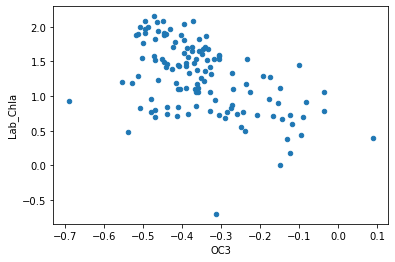

In [1530]:
df_test = pd.concat([X_sel, y_trans_log10], axis=1)
df_test
df_test.plot.scatter('OC3', 'Lab_Chla')

In [1508]:
from sklearn.preprocessing import PolynomialFeatures

poly_featureGenerator = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True, order='C')
X_sel = poly_featureGenerator.fit_transform(X_sel).copy()

In [1509]:
# X_sel[['SiteNumber', 'Month']] = X_sel[['SiteNumber', 'Month']].astype(str)

# cat_col = X_sel.select_dtypes(include="object").columns
# num_col = X_sel.select_dtypes(exclude="object").columns

<AxesSubplot:title={'center':'Lab_Chla'}, xlabel='SiteNumber'>

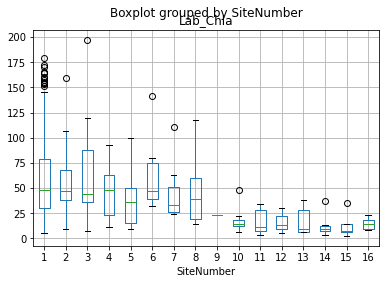

In [1510]:
chl_data[(chl_data['Date'].dt.month==8) | (chl_data['Date'].dt.month==7)].boxplot(column='Lab_Chla', by='SiteNumber')

In [1511]:
# #from sklearn.preprocessing import scale
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_sel_standard = scaler.fit_transform(X_sel)
# plt.hist(X_sel_standard)

In [1512]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler

# # Preprocessing for numerical data
# numerical_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# # Preprocessing for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, num_col),
#         ('cat', categorical_transformer, cat_col)
#     ])

# Model development

In [1531]:
# ## import models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

# create a pipeline
from sklearn.pipeline import Pipeline
my_pipeline = Pipeline(steps=[
                              ('model', 'passthrough')
                             ])

# Define pipeline parameters

pipe_par = [
#            {'model': [RandomForestRegressor()],
#            },
#            {'model': [XGBRegressor()],
#             "model__n_estimators": [100], 
#             "model__max_depth": [4],
#             "model__learning_rate": [0.05],
#             "model__booster": ['gbtree'],
#             "model__n_jobs" : [-1],
#             "model__reg_alpha": [0.01],
#  #           "model__reg_lambda": [0.01],
#             "model__gamma": [0],
#             "model__colsample_bytree": [.5]
#            },
#            {'model': [SVR()],
#             "model__kernel": ['rbf'],
#             "model__gamma" : ['scale'],
#             "model__C" : [.1, .2, .4, .8,  .16, .32, .64, 1.28, 2.5, 5.12, 10.24]
#           },
             {'model': [LinearRegression()]},
#             {'model': [Lasso()],
#             "model__alpha" : [.1, .2, .4, .8,  .16, .32, .64, 1.28, 2.5, 5.12, 10.24]
#             },
#             {'model': [Ridge()],
#             "model__alpha" : [.1, .2, .4, .8,  .16, .32, .64, 1.28, 2.5, 5.12, 10.24, 20.48, 40.96]
#             },
#             {'model': [PLSRegression()]},
#            {'model': [Lasso()]},
#            {'model': [GradientBoostingRegressor()],
#             "model__n_estimators": [100],
#             "model__learning_rate": [0.05],
#             "model__max_depth": [4],
#             "model__max_features":['sqrt'],
#             "model__min_samples_leaf":[15],
#             "model__min_samples_split":[10], 
#             "model__loss":['huber']
 #           } ,
#             {'model': [LGBMRegressor()],
#             "model__objective":['regression'], 
#             "model__n_estimators": [100], 
#             "model__num_leaves" : [4],
#             "model__learning_rate": [0.01],
#             "model__max_bin":[200],
#             "model__bagging_fraction":[0.75],
#             "model__bagging_freq":[5],
#             "model__bagging_seed":[7],
#             "model__feature_fraction" : [0.2],
#             "model__feature_fraction_seed": [7],
#            } ,            
  
]


# #model = DecisionTreeRegressor(max_depth=100)
# #model = RandomForestRegressor(n_estimators=100, random_state=0)
#model = XGBRegressor(booster='gblinear',n_estimators=100, random_state=0, learning_rate = 0.1)
#model = SVR(kernel = 'rbf', gamma = 'scale')
#model = LinearRegression()
# #model = PLSRegression(n_components = 4)


In [1532]:
from sklearn.model_selection import GridSearchCV
gds = GridSearchCV(my_pipeline, pipe_par, n_jobs=-1, cv=5, scoring = 'neg_mean_absolute_error')

gds.fit(X_sel, y_trans_log10)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', 'passthrough')]),
             n_jobs=-1, param_grid=[{'model': [LinearRegression()]}],
             scoring='neg_mean_absolute_error')

In [1533]:
print(gds.best_params_)
df_results = pd.DataFrame.from_dict(gds.cv_results_)
df_results[['param_model', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]

{'model': LinearRegression()}


,param_model,mean_fit_time,mean_test_score,rank_test_score
0,LinearRegression(),0.002606,-0.38131,1


In [1534]:
# cross validation and accuracy assessment of model
from sklearn.model_selection import cross_val_score
mae_loginput = 10**(-1 * cross_val_score(gds, X_sel, y_trans_log10, cv=5, scoring='neg_mean_absolute_error').mean())
round(mae_loginput,2)

2.41

<module 'matplotlib.pyplot' from 'C:\\Users\\amchegoo\\Anaconda3\\envs\\p2_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

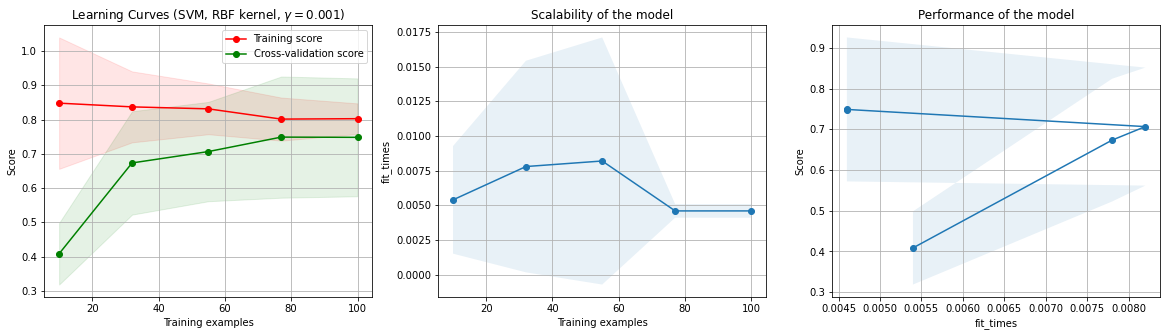

In [1409]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,), dtype={int, float}
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt
    


title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = gds.best_estimator_
plot_learning_curve(estimator, title, X_sel, y_trans_log10,
                    cv=cv, n_jobs=-1)

In [1535]:
# getting predictions from cross validation
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(gds, X_sel, y_trans_log10, cv=5)

# Implement MDN

In [1538]:
# prepare and save data to import to MDN
sat_ref_MDN = np.array(sat_ref.dropna(axis=0))[:,:7]
print(sat_ref_MDN.shape)
np.savetxt("sat_ref_MDN.csv", sat_ref_MDN, delimiter=",")

(125, 7)


In [1539]:
%%cmd
## change kernel (environment) to MDN_env to run this cell - I put the MDN folder in the directory of MDN_env
# Run MDN with bash or using !
python -m MDN --sensor S2A sat_ref_MDN.csv

Microsoft Windows [Version 10.0.15063]
(c) 2017 Microsoft Corporation. All rights reserved.

(p2_env) C:\Users\amchegoo\Thesis_projects\p2_BPL_chla_SatData>## change kernel (environment) to MDN_env to run this cell - I put the MDN folder in the directory of MDN_env

(p2_env) C:\Users\amchegoo\Thesis_projects\p2_BPL_chla_SatData># Run MDN with bash or using !

(p2_env) C:\Users\amchegoo\Thesis_projects\p2_BPL_chla_SatData>python -m MDN --sensor S2A sat_ref_MDN.csv

(p2_env) C:\Users\amchegoo\Thesis_projects\p2_BPL_chla_SatData>

'##' is not recognized as an internal or external command,
operable program or batch file.
'#' is not recognized as an internal or external command,
operable program or batch file.
C:\Users\amchegoo\Anaconda3\envs\p2_env\python.exe: No module named MDN


In [371]:
# read the output of MDN model and make format consistent with other models' outputs 
y_pred = pd.read_csv('MDN_sat_ref_MDN.csv')
y_pred = np.transpose(np.array(np.log10(y_pred)))
y_pred

In [372]:
from sklearn.metrics import mean_absolute_error

mae_loginput = 10**(mean_absolute_error(np.transpose(y_pred), y_trans_log10))
round(mae_loginput,2)

# bst_oli (Cao et al., 2020)

In [373]:
# # Rayleigh-corrected reflectance should be intrudeced to the model as input
# import xgboost as xgb
# bst = xgb.Booster({'nthread': 4})  # init model
# bst.load_model('bst_oli\chl_bst_model_release.model')  # load data
# dtest = xgb.DMatrix(X_sel_standard)
# y_pred = np.log10(bst.predict(dtest))
# y_pred

# validation performance

In [1536]:
from scipy.io import savemat
savemat('y_pred.mat', {'y_pred': y_pred})
#y_trans_log10[y_trans_log10 == 0] = 0.05
savemat('y.mat', {'y': np.array(y_trans_log10)})

In [1412]:
y_pred

array([0.91723595, 0.95394214, 0.87651095, 0.89641956, 0.94158145,
       0.96021709, 0.92153774, 1.16074811, 1.31786568, 1.33161067,
       1.28540702, 1.36160356, 1.07602458, 0.84523567, 0.86694205,
       0.80123299, 1.35978389, 1.32006613, 1.38096401, 1.98290379,
       1.53273951, 1.98215832, 1.66786552, 1.70195633, 1.31471576,
       1.05646422, 1.07933546, 1.88869773, 1.9523162 , 1.9091088 ,
       1.41872462, 1.14135894, 1.07300763, 0.83718753, 0.96095195,
       1.01795238, 1.00086342, 0.65173735, 0.63412469, 0.4267126 ,
       0.98055128, 0.99917696, 0.29908889, 0.827771  , 0.79890592,
       1.16503405, 1.21168977, 1.46513311, 1.94546047, 1.90405023,
       2.0022018 , 1.97622551, 1.92844734, 1.40364739, 1.48658315,
       1.3823594 , 0.98529046, 1.86272393, 1.61831437, 1.40986649,
       1.22937574, 1.42635017, 1.4504912 , 1.38063068, 1.35141769,
       1.6343624 , 1.24414931, 1.67278832, 1.54620723, 1.64413964,
       1.60070356, 1.11029918, 1.1420982 , 1.74203051, 1.28930

# Spatial check

In [677]:
# imgs['Rrs_1610'][0,:,:].plot.imshow()
# plt.gca().invert_yaxis()

# R = nc.variables['Rrs_665'][:]
# G = nc.variables['Rrs_559'][:] 
# B = nc.variables['Rrs_442'][:] 

In [678]:
import fiona

shp = fiona.open("..\Data\Maps_BP\BP - Study Site\BP_Shapefile\Buffalo_Pound.shp")
pol = shp.next()

<ipython-input-678-783b5be4fcfc>:4: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  pol = shp.next()


In [679]:
from shapely.geometry import Point, shape
polygon = shape(pol['geometry'])

In [680]:
dataset = nc.Dataset(path_img + img_list[62])
dataset
lats = dataset.variables['lat'][:].flatten()
lons = dataset.variables['lon'][:].flatten()

In [681]:
mask_flat = []
for i in range(len(lats)):
    point = Point(lons[i], lats[i])
    mask_flat.append(point.within(polygon))

In [682]:
from netCDF4 import Dataset
#Ref = [[]*0]*0 
#for index, row in merged_data_3daylag.iterrows():
dataset = Dataset(path_img + img_list[62])
keys = dataset.variables.keys()
dataset_1D = {}
for key in keys:
    dataset_1D[key] = dataset.variables[key][:].flatten()
    


In [683]:
Ref = [[]*0]*0 
for i in range(0,len(dataset_1D['lat'])):
    if mask_flat[i] == True and dataset_1D['l2_flags'][i] == 0:
        Rrs = []
        for key in keys:
            if 'Rrs' in key:        
                Rrs.append(dataset_1D[key][i])
        Ref.append(Rrs)
        
ww = (np.array(Ref))   
ww = ww[:, :6]

In [684]:
# from sklearn.preprocessing import scale 
# ww_scaled = scale(ww)
# ww_scaled

In [685]:
# def reject_outliers(data, m):
#     return abs(data - np.median(data)) > m * np.std(data)

# idx = ww.copy()
# for i in range(0, ww.shape[1]):
#     data = ww[:,i]
#     idx[:,i] = reject_outliers(data, 2)

# idx_outlier = idx.sum(axis=1) != 0

In [686]:
model.fit(X_sel, y_trans_log10)
values_pred = model.predict(ww)
# idx_values_pred_outlier = reject_outliers(values_pred, 2)
# values_pred[idx_values_pred_outlier] = 'NaN'
values_pred_unlog = 10 ** values_pred
# values_pred_unlog[idx_outlier] = 'NaN'


In [687]:
image_flat = np.array(dataset_1D['Rrs_492']) 
idx = ~np.isnan(image_flat) & np.array(mask_flat)
image_flat[idx]= values_pred_unlog
image_flat[~idx] = 'NaN'

In [688]:
image = image_flat.reshape(dataset.dimensions['y'].size, dataset.dimensions['x'].size)

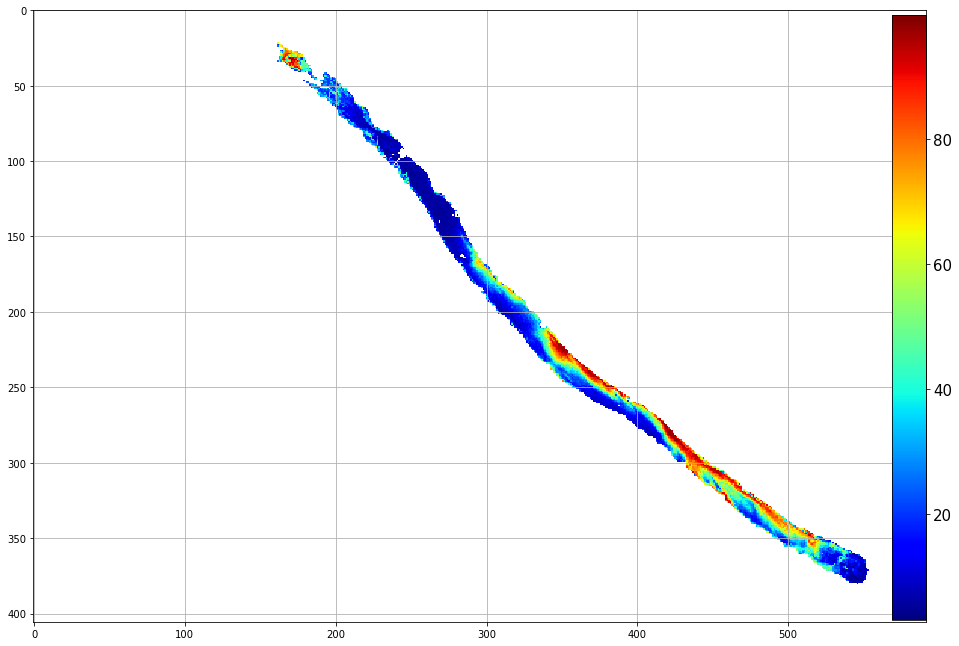

In [689]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.figure(figsize = [16,12])
heatmap = plt.imshow(image, cmap='jet', interpolation='nearest')
plt.grid()

cbar = plt.colorbar(heatmap, cax = ax.add_axes([.87, 0.15, 0.03, 0.7]))
cbar.ax.tick_params(labelsize=15) 



In [690]:
ax.savefig('test.png',dpi=500, format='png')

# temporal check

In [691]:
samples_sel = samples[(samples['Date_insitu'].dt.year==2018) & (samples['SiteNumber']==1) & (samples['date_diff']=='0 days')]
samples_sel

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff,pix_Y,pix_X,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
55,2018-05-30,1,50.586139,-105.384833,2.523246,2018-05-30,15,0 days,342,491,0.005580,0.004144,0.004536,0.001375,0.001062,0.002429,0.002443,0.001498,0.002220,0.000000,0.000985
56,2018-06-07,1,50.586139,-105.384833,3.544571,2018-06-07,49,0 days,342,491,0.002765,0.006234,0.011045,0.004558,0.004279,0.006239,0.006352,0.006323,0.005919,0.000782,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2018-09-05,1,50.586139,-105.384833,35.756304,2018-09-05,56,0 days,342,491,0.001424,0.004137,0.013183,0.005190,0.006793,0.002993,0.003314,0.002551,0.002055,0.000387,0.000000
106,2018-09-07,1,50.586139,-105.384833,31.048575,2018-09-07,23,0 days,342,491,0.001727,0.005300,0.014841,0.007728,0.008663,0.005440,0.005488,0.004739,0.004740,0.000887,0.000000


In [692]:
ref_sel = samples_sel.filter(like='Rrs')
ref_sel

,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
55,0.005580,0.004144,0.004536,0.001375,0.001062,0.002429,0.002443,0.001498,0.002220,0.000000,0.000985
56,0.002765,0.006234,0.011045,0.004558,0.004279,0.006239,0.006352,0.006323,0.005919,0.000782,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
105,0.001424,0.004137,0.013183,0.005190,0.006793,0.002993,0.003314,0.002551,0.002055,0.000387,0.000000
106,0.001727,0.005300,0.014841,0.007728,0.008663,0.005440,0.005488,0.004739,0.004740,0.000887,0.000000


In [693]:
y_pred = model.predict(ref_sel.iloc[:,:6])

In [334]:
chl_data_sel = chl_data[(chl_data['Date'].dt.year==2018) & (chl_data['SiteNumber']==1)]
chl_data_sel

,Date,SiteNumber,latitude,Longitude,Lab_Chla
822,2018-05-29,1,50.586139,-105.384833,2.014052
823,2018-05-30,1,50.586139,-105.384833,2.523246
824,2018-05-31,1,50.586139,-105.384833,3.544571
825,2018-06-01,1,50.586139,-105.384833,4.056406
826,2018-06-02,1,50.586139,-105.384833,5.081949
...,...,...,...,...,...
1008,2018-09-30,1,50.586139,-105.384833,19.053354
1009,2018-10-01,1,50.586139,-105.384833,16.454429
1010,2018-10-02,1,50.586139,-105.384833,14.378219
1011,2018-10-03,1,50.586139,-105.384833,12.823008


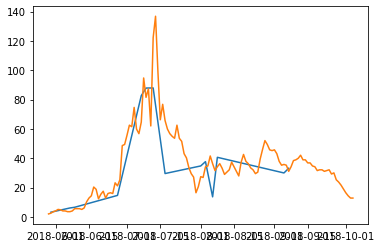

In [336]:
plt.plot(samples_sel['Date_insitu'],10**y_pred)
plt.plot(chl_data_sel['Date'], chl_data_sel['Lab_Chla'])
plt.show()